# Hand Tracking Pipeline: 
## 1. Hand Detection

The first step is to detect hands in the initial frame of the video. This is done using Google MediaPipe's Hand Landmarker model, which is based on machine learning techniques.

### Hand Landmark Detection

The Hand Landmarker model detects 21 3D landmarks on a hand. These landmarks represent key points such as finger joints and tips. The model outputs the normalized coordinates of these landmarks.

For each detected hand, we get:

$L = \{(x_i, y_i, z_i) | i = 1, ..., 21\}$

where $(x_i, y_i, z_i)$ are the normalized coordinates of the i-th landmark.

### Bounding Box Calculation

From these landmarks, we calculate a bounding box around the hand:

$x_{min} = \min_{i} x_i, \quad x_{max} = \max_{i} x_i$

$y_{min} = \min_{i} y_i, \quad y_{max} = \max_{i} y_i$

The bounding box is then converted to pixel coordinates:

$x_{min}^{px} = x_{min} \cdot w, \quad x_{max}^{px} = x_{max} \cdot w$

$y_{min}^{px} = y_{min} \cdot h, \quad y_{max}^{px} = y_{max} \cdot h$

where $w$ and $h$ are the width and height of the image.

## 2. Hand Tracking

For tracking hands in subsequent frames, we use the Segment Anything Model 2 (SAM 2).

### SAM 2 Model

SAM 2 is a powerful image segmentation model that can generate masks for objects given prompts. In our case, we use the bounding boxes from the hand detection step as prompts.

### Mask Generation

For each frame $t$, we provide SAM 2 with:
1. The current frame image $I_t$
2. The bounding box(es) $B_t = \{(x_{min}, y_{min}, x_{max}, y_{max})_i\}$ from the previous frame

SAM 2 then generates a mask $M_t$ for each hand:

$M_t = SAM2(I_t, B_t)$

### Temporal Consistency

To maintain temporal consistency, SAM 2 uses information from previous frames. This helps in tracking hands even when they're partially occluded or in challenging poses.

## Mathematical Formulation

The overall pipeline can be formulated as follows:

1. For the first frame $t=0$:
   $L_0 = HandLandmarker(I_0)$
   $B_0 = BoundingBox(L_0)$
   $M_0 = SAM2(I_0, B_0)$

2. For subsequent frames $t > 0$:
   $M_t = SAM2(I_t, B_{t-1})$
   $B_t = BoundingBox(M_t)$

This process is repeated for each frame in the video, resulting in a sequence of masks that track the hands throughout the video.

The final output is a video where the hand regions are masked in each frame, effectively tracking the hand movements over time.


### Installing Required Libraries

Before starting with the implementation, we need to ensure that the necessary Python libraries are installed. This code cell installs the following:

1. **`mediapipe`**: A framework by Google for building perception pipelines, which we'll use for hand detection in videos. It provides pre-trained models and tools for various tasks like face detection, hand tracking, etc.

2. **`opencv-python`**: A library for computer vision tasks, essential for reading, processing, and writing video files.

```python
!pip install -q mediapipe opencv-python
```

- The `!` indicates that this command is being run in a Jupyter Notebook, allowing you to execute shell commands.
- The `-q` flag suppresses unnecessary output, making the installation process cleaner.

This ensures all dependencies required for video processing and hand detection are available in your Python environment.

In [ ]:
!pip install -q mediapipe opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 47.1 MB/s eta 0:00:00


### Detecting Hands in Images Using MediaPipe

This code sets up MediaPipe and OpenCV to detect hands in an image and extract their bounding boxes. Below is an explanation of each part:

---

#### Importing Necessary Libraries
```python
import cv2
import mediapipe as mp
import numpy as np
```
- **`cv2`**: OpenCV library for image and video processing.
- **`mediapipe`**: Library for hand detection and tracking.
- **`numpy`**: For numerical computations, although not explicitly used in this code yet.

---

#### Initializing MediaPipe Hands
```python
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=0.5)
```
- **`mp.solutions.hands`**: Provides pre-trained models for hand detection.
- **`Hands`**:
  - `static_image_mode=True`: Ensures that detection runs on a per-image basis (no tracking across frames).
  - `max_num_hands=2`: Limits the detection to at most 2 hands.
  - `min_detection_confidence=0.5`: Minimum confidence score to consider a hand detection valid.

---

#### Defining the Hand Detection Function
```python
def detect_hands(image):
    # Convert the image to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
```
- OpenCV reads images in **BGR** format, while MediaPipe requires **RGB**. The `cvtColor` function converts the image.

```python
    # Process the image and detect hands
    results = hands.process(image_rgb)
```
- **`hands.process(image_rgb)`**: Detects hand landmarks in the RGB image. Results contain landmark positions and additional information.

```python
    bounding_boxes = []
```
- An empty list to store the bounding boxes for detected hands.

---

#### Extracting Hand Landmarks and Bounding Boxes
```python
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            # Get bounding box coordinates
            x_coords = [landmark.x for landmark in hand_landmarks.landmark]
            y_coords = [landmark.y for landmark in hand_landmarks.landmark]
```
- **`multi_hand_landmarks`**: Contains a list of detected hand landmarks.
- **`landmark.x` and `landmark.y`**: Provide normalized coordinates (values between 0 and 1).

```python
            x_min, x_max = min(x_coords), max(x_coords)
            y_min, y_max = min(y_coords), max(y_coords)
```
- Calculates the minimum and maximum x/y values to define a bounding box around the hand.

---

#### Converting Normalized Coordinates to Pixel Coordinates
```python
            h, w, _ = image.shape
            x_min, x_max = int(x_min * w), int(x_max * w)
            y_min, y_max = int(y_min * h), int(y_max * h)
```
- MediaPipe provides normalized coordinates. These are scaled to pixel values using the image's width (`w`) and height (`h`).

---

#### Appending Bounding Boxes
```python
            bounding_boxes.append([x_min, y_min, x_max, y_max])
```
- Each bounding box is stored as a list `[x_min, y_min, x_max, y_max]`.

---

#### Returning Bounding Boxes
```python
    return bounding_boxes
```
- The function outputs a list of bounding boxes for all detected hands.



In [ ]:
import cv2
import mediapipe as mp
import numpy as np

# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=0.5)

# Function to detect hands and return bounding boxes
def detect_hands(image):
    # Convert the image to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Process the image and detect hands
    results = hands.process(image_rgb)

    bounding_boxes = []

    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            # Get bounding box coordinates
            x_coords = [landmark.x for landmark in hand_landmarks.landmark]
            y_coords = [landmark.y for landmark in hand_landmarks.landmark]

            x_min, x_max = min(x_coords), max(x_coords)
            y_min, y_max = min(y_coords), max(y_coords)

            # Convert normalized coordinates to pixel coordinates
            h, w, _ = image.shape
            x_min, x_max = int(x_min * w), int(x_max * w)
            y_min, y_max = int(y_min * h), int(y_max * h)

            bounding_boxes.append([x_min, y_min, x_max, y_max])

    return bounding_boxes



### Processing the First Frame of a Video to Detect Hands

In this code cell, we load a video, process its first frame to detect hands using the `detect_hands` function, and visualize the results with bounding boxes drawn around the detected hands.

---

#### 1. Loading the Video
```python
video_path = '/content/test.mp4'
cap = cv2.VideoCapture(video_path)
```
- **`video_path`**: Specifies the path to the video file.
- **`cv2.VideoCapture(video_path)`**: Opens the video file for processing. The `cap` object allows us to read frames from the video sequentially.

---

#### 2. Reading the First Frame
```python
ret, frame = cap.read()
```
- **`cap.read()`**: Reads the next frame from the video.
  - `ret`: A boolean indicating whether the frame was successfully read.
  - `frame`: The image data of the frame.

---

#### 3. Processing the Frame
If the first frame is successfully read:
```python
if ret:
    # Detect hands in the first frame
    hand_boxes = detect_hands(frame)
```
- **`detect_hands(frame)`**: Calls the previously defined function to detect hands in the current frame, returning bounding box coordinates.

---

#### 4. Drawing Bounding Boxes
```python
    for box in hand_boxes:
        cv2.rectangle(frame, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)
```
- **`cv2.rectangle`**: Draws rectangles (bounding boxes) on the frame.
  - `(box[0], box[1])`: Top-left corner of the bounding box.
  - `(box[2], box[3])`: Bottom-right corner of the bounding box.
  - `(0, 255, 0)`: Green color in BGR format.
  - `2`: Thickness of the rectangle.

---

#### 5. Displaying the Frame
```python
    from google.colab.patches import cv2_imshow
    cv2_imshow(frame)
```
- **`cv2_imshow`**: Displays the processed frame in Google Colab. It is specific to Colab and works as an alternative to `cv2.imshow`, which is not supported in Colab.

---

#### 6. Printing Results
```python
    print(f"Detected {len(hand_boxes)} hands")
    print("Bounding boxes:", hand_boxes)
```
- Outputs the number of detected hands and the corresponding bounding box coordinates to the console.

---

#### 7. Handling Failure to Read the Video
```python
else:
    print("Failed to read the video")
```
- If `ret` is `False`, it indicates the video could not be loaded properly.

---

#### 8. Releasing Resources
```python
cap.release()
```
- Frees the video capture object, ensuring resources are properly released after processing.



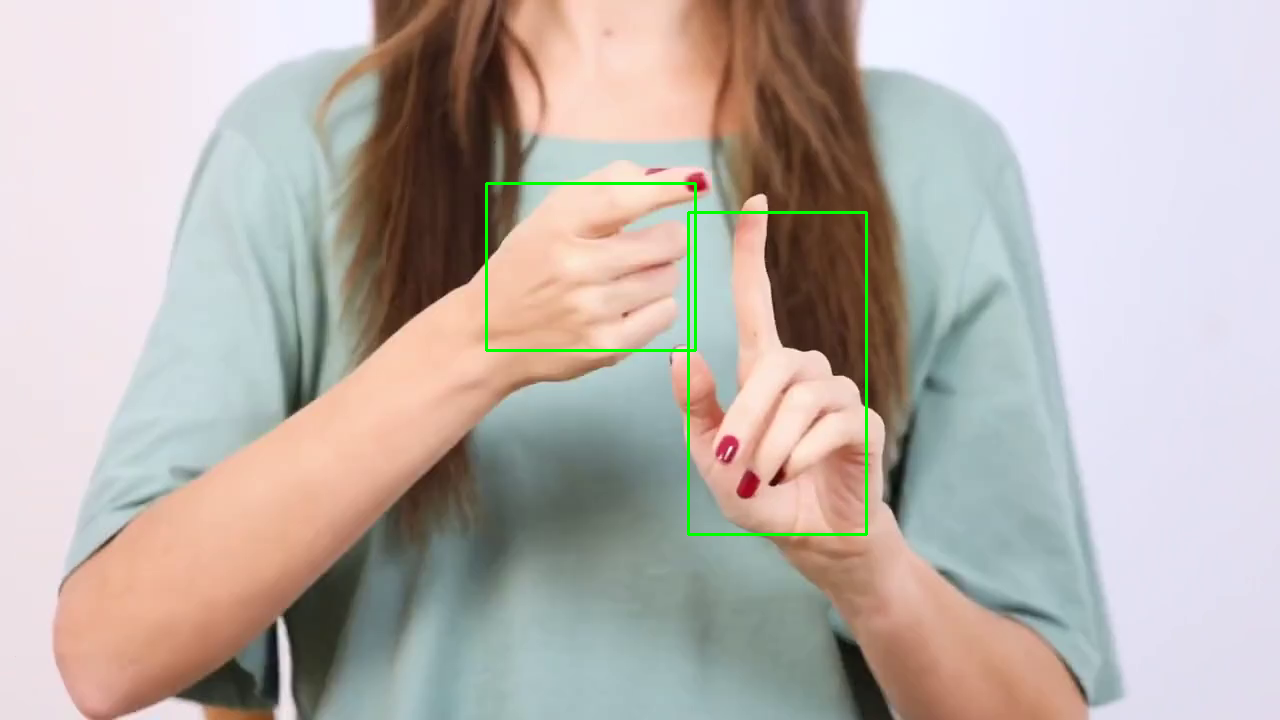

Detected 2 hands
Bounding boxes: [[486, 183, 695, 350], [688, 212, 866, 534]]


In [ ]:
# Load the video
video_path = '/content/test.mp4'
cap = cv2.VideoCapture(video_path)

# Read the first frame
ret, frame = cap.read()

if ret:
    # Detect hands in the first frame
    hand_boxes = detect_hands(frame)

    # Draw bounding boxes on the frame
    for box in hand_boxes:
        cv2.rectangle(frame, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)

    # Display the result
    from google.colab.patches import cv2_imshow
    cv2_imshow(frame)

    print(f"Detected {len(hand_boxes)} hands")
    print("Bounding boxes:", hand_boxes)
else:
    print("Failed to read the video")

# Release the video capture object
cap.release()


### Installing Necessary Libraries and Model Files

This code cell installs all the essential libraries and downloads the required model weights to set up the environment for hand detection and segmentation.

---

#### 1. Installing MediaPipe and OpenCV
```python
!pip install -q mediapipe opencv-python
```
- **`mediapipe`**: A library for real-time perception, used for hand detection and tracking.
- **`opencv-python`**: A computer vision library for processing images and videos.

The `-q` flag suppresses output for a cleaner installation process.

---

#### 2. Installing Segment Anything (SAM)
```python
!pip install -q git+https://github.com/facebookresearch/segment-anything.git
```
- Installs **Segment Anything**, a state-of-the-art segmentation library developed by Meta (formerly Facebook).
- **`git+https://github.com/...`**: Fetches the latest version of the library directly from its GitHub repository.

---

#### 3. Downloading SAM Pre-trained Model
```python
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
```
- **`wget`**: Downloads the pre-trained model weights for SAM.
- **`sam_vit_h_4b8939.pth`**: The specific checkpoint file containing weights for SAM’s vision transformer (ViT) model.

The `-q` flag ensures the download happens quietly without verbose output.

---

### Why This Is Important
1. **MediaPipe** is used for detecting hand regions in images/videos.
2. **Segment Anything** is used for precise segmentation of detected hands.
3. The SAM model weights (`sam_vit_h_4b8939.pth`) are essential for the segmentation tasks to work.

This step ensures that all required tools and pre-trained models are ready for further implementation.

In [ ]:
!pip install -q mediapipe opencv-python
!pip install -q git+https://github.com/facebookresearch/segment-anything.git
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

  Preparing metadata (setup.py) ... done




### Importing Libraries for Hand Detection and Segmentation

This code imports the necessary libraries and modules to perform hand detection using MediaPipe and precise segmentation using the Segment Anything Model (SAM). Let’s break it down:

---

#### 1. Importing OpenCV for Image Processing
```python
import cv2
```
- **`cv2`**: Part of the OpenCV library, used for tasks such as:
  - Reading and displaying images/videos.
  - Drawing bounding boxes and overlays.
  - General image processing.

---

#### 2. Importing MediaPipe for Hand Detection
```python
import mediapipe as mp
```
- **`mediapipe`**: A framework by Google for hand detection and tracking. It provides pre-trained models and utilities to detect hand landmarks in images and videos.

---

#### 3. Importing NumPy for Numerical Operations
```python
import numpy as np
```
- **`numpy`**: A library for handling numerical data, such as arrays and matrices. 
- Usage here includes:
  - Manipulating image data.
  - Performing pixel-level operations.

---

#### 4. Importing PyTorch for Deep Learning
```python
import torch
```
- **`torch`**: A deep learning framework used here to load and run the SAM model.

---

#### 5. Importing SAM for Hand Segmentation
```python
from segment_anything import SamPredictor, sam_model_registry
```
- **`segment_anything`**: A library from Meta that provides pre-trained models for segmentation tasks.
- **`SamPredictor`**: A utility class used for making predictions (segmentations) on given images.
- **`sam_model_registry`**: A registry to access and load different variants of SAM models, such as ViT (Vision Transformer).

---

### Why These Imports Are Important
This combination of libraries is essential for achieving the task of automatic hand tracking:
1. **MediaPipe** detects hands and provides bounding box information.
2. **OpenCV** handles video/image processing and visualization.
3. **PyTorch** loads and utilizes SAM's pre-trained deep learning models.
4. **Segment Anything** performs precise segmentation of the detected hands.

This setup prepares the environment to combine detection and segmentation into an end-to-end pipeline.

In [ ]:
import cv2
import mediapipe as mp
import numpy as np
import torch
from segment_anything import SamPredictor, sam_model_registry




### Configuring GPU for Efficient Computation

This code sets up the computational device (CPU or GPU) and clears the GPU memory cache to optimize performance.

---

#### 1. Checking for GPU Availability
```python
device = 'cuda' if torch.cuda.is_available() else 'cpu'
```
- **`torch.cuda.is_available()`**: Checks if a CUDA-compatible GPU is available on the system.
  - If `True`, the model will utilize the GPU for computations (`'cuda'`).
  - If `False`, the model falls back to using the CPU (`'cpu'`).

Why use GPU?  
- GPUs are significantly faster than CPUs for tasks like deep learning and image segmentation because of their parallel processing capability.

---

#### 2. Clearing GPU Memory Cache
```python
torch.cuda.empty_cache()
```
- **`torch.cuda.empty_cache()`**: Frees up unused memory from the GPU cache.  
  - Useful in scenarios where prior operations have allocated GPU memory that is no longer in use.
  - Ensures that maximum GPU memory is available for the upcoming computations.

---

### Why This Step Is Important
1. **Device Configuration**: Ensures the program runs on the best available hardware (GPU if possible).
2. **Performance Optimization**: Clearing the GPU cache avoids memory fragmentation, reduces the risk of "out of memory" errors, and improves computational efficiency.

This step is especially crucial for large models like SAM, which require significant computational resources.

In [ ]:
# GPU configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.cuda.empty_cache()



### Hand Detection and Tracking with SAM

This code implements a complete pipeline for detecting hands in video frames, applying segmentation using the Segment Anything Model (SAM), and saving the processed output as a new video.

---

#### 1. Detecting Hands in an Image
```python
def detect_hands(image):
    mp_hands = mp.solutions.hands
    hands = mp_hands.Hands(
        static_image_mode=False,
        max_num_hands=2,
        min_detection_confidence=0.5,
        model_complexity=1
    )
```
- **MediaPipe Hands Configuration**:
  - `static_image_mode=False`: Optimized for videos (tracking hand locations across frames).
  - `max_num_hands=2`: Detects up to two hands.
  - `min_detection_confidence=0.5`: Filters out low-confidence detections.
  - `model_complexity=1`: Affects detection accuracy and runtime (default is 1).

```python
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = hands.process(image_rgb)
```
- Converts the input image to RGB format (required by MediaPipe).
- Processes the frame to detect hand landmarks.

```python
    bounding_boxes = []

    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            x_coords = [landmark.x for landmark in hand_landmarks.landmark]
            y_coords = [landmark.y for landmark in hand_landmarks.landmark]
```
- Extracts x and y coordinates for all hand landmarks to compute bounding boxes.

```python
            x_min, x_max = min(x_coords), max(x_coords)
            y_min, y_max = min(y_coords), max(y_coords)

            h, w, _ = image.shape
            bounding_boxes.append([
                int(x_min * w),
                int(y_min * h),
                int(x_max * w),
                int(y_max * h)
            ])
```
- Normalized coordinates are scaled to pixel coordinates.
- Appends bounding boxes to the list.

```python
    return bounding_boxes
```
- Returns the list of detected bounding boxes.

---

#### 2. Tracking Hands in a Video and Applying SAM
```python
def track_hands(input_path, output_path):
```
- A function to process the video frame by frame, detect hands, and apply segmentation.

```python
    sam_checkpoint = "sam_vit_h_4b8939.pth"
    model_type = "vit_h"

    sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
    sam.to(device=device)
    predictor = SamPredictor(sam)
```
- **SAM Model Setup**:
  - Loads the `sam_vit_h_4b8939.pth` checkpoint for the Vision Transformer (ViT) SAM model.
  - Moves the model to the GPU or CPU (based on availability).
  - Initializes the `SamPredictor` for segmentation.

```python
    cap = cv2.VideoCapture(input_path)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
```
- **Video Setup**:
  - Opens the input video and retrieves its width, height, and frame rate.
  - Initializes a `VideoWriter` object to save the processed video.

---

#### 3. Processing Frames
```python
    frame_count = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_count += 1
        print(f"Processing frame {frame_count}", end='\r')
```
- Reads video frames one by one.
- Displays the progress in the console.

```python
        hand_boxes = detect_hands(frame)
        if not hand_boxes:
            out.write(frame)
            continue
```
- Detects hands in the current frame.
- If no hands are detected, writes the unmodified frame to the output video.

---

#### 4. Applying SAM for Segmentation
```python
        predictor.set_image(frame)
        boxes_tensor = torch.tensor(hand_boxes, device=device)

        transformed_boxes = predictor.transform.apply_boxes_torch(
            boxes_tensor,
            frame.shape[:2]
        )
```
- **SAM Preprocessing**:
  - Sets the frame as the input for SAM.
  - Converts bounding boxes to tensors and transforms them for SAM’s processing.

```python
        masks, _, _ = predictor.predict_torch(
            point_coords=None,
            point_labels=None,
            boxes=transformed_boxes,
            multimask_output=False
        )
```
- Predicts segmentation masks for the detected hand bounding boxes.

---

#### 5. Overlaying Masks
```python
        for mask in masks:
            mask = mask.cpu().numpy()[0]
            frame[mask] = frame[mask] * 0.5 + np.array([0, 0, 255]) * 0.5
```
- Converts the mask to a NumPy array.
- Applies a red overlay to the segmented regions on the frame.

---

#### 6. Finalizing the Output
```python
        out.write(frame)

    cap.release()
    out.release()
    print("\nProcessing complete!")
```
- Writes the processed frame to the output video.
- Releases resources after processing is complete.



In [ ]:
def detect_hands(image):
    mp_hands = mp.solutions.hands
    hands = mp_hands.Hands(
        static_image_mode=False,
        max_num_hands=2,
        min_detection_confidence=0.5,
        model_complexity=1
    )

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = hands.process(image_rgb)
    bounding_boxes = []

    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            x_coords = [landmark.x for landmark in hand_landmarks.landmark]
            y_coords = [landmark.y for landmark in hand_landmarks.landmark]

            x_min, x_max = min(x_coords), max(x_coords)
            y_min, y_max = min(y_coords), max(y_coords)

            h, w, _ = image.shape
            bounding_boxes.append([
                int(x_min * w),
                int(y_min * h),
                int(x_max * w),
                int(y_max * h)
            ])

    return bounding_boxes

def track_hands(input_path, output_path):
    # Initialize SAM model
    sam_checkpoint = "sam_vit_h_4b8939.pth"
    model_type = "vit_h"

    sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
    sam.to(device=device)
    predictor = SamPredictor(sam)

    # Video setup
    cap = cv2.VideoCapture(input_path)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    frame_count = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_count += 1
        print(f"Processing frame {frame_count}", end='\r')

        # Detect hands and convert to tensor
        hand_boxes = detect_hands(frame)
        if not hand_boxes:
            out.write(frame)
            continue

        predictor.set_image(frame)
        boxes_tensor = torch.tensor(hand_boxes, device=device)

        # Transform boxes for SAM
        transformed_boxes = predictor.transform.apply_boxes_torch(
            boxes_tensor,
            frame.shape[:2]
        )

        # Predict masks with explicit None for unused prompts
        masks, _, _ = predictor.predict_torch(
            point_coords=None,
            point_labels=None,
            boxes=transformed_boxes,
            multimask_output=False
        )

        # Apply mask overlay
        for mask in masks:
            mask = mask.cpu().numpy()[0]
            frame[mask] = frame[mask] * 0.5 + np.array([0, 0, 255]) * 0.5

        out.write(frame)

    cap.release()
    out.release()
    print("\nProcessing complete!")


### Running the Hand Tracking and Segmentation Pipeline

This code runs the complete pipeline for detecting and segmenting hands in a video, saves the processed output, and previews the first frame of the resulting video.

---

#### 1. Specifying Input and Output Paths
```python
input_path = "/content/test.mp4"
output_path = "/content/output.mp4"
```
- **`input_path`**: Path to the input video file (`test.mp4`) that will be processed.
- **`output_path`**: Path where the processed video (`output.mp4`) will be saved.

---

#### 2. Running the Pipeline
```python
track_hands(input_path, output_path)
```
- Calls the `track_hands` function, which:
  - Reads frames from the input video.
  - Detects hands and applies segmentation using SAM.
  - Saves the processed frames to the specified output video file.

---

#### 3. Previewing the Processed Video
```python
from google.colab.patches import cv2_imshow
cap = cv2.VideoCapture(output_path)
ret, frame = cap.read()
```
- **`cv2.VideoCapture(output_path)`**: Opens the processed video file for reading.
- **`cap.read()`**: Reads the first frame of the output video.
  - `ret`: Indicates if the frame was successfully read.
  - `frame`: Contains the image data of the frame.

---

#### 4. Displaying the First Frame
```python
if ret:
    cv2_imshow(frame)
```
- **`cv2_imshow(frame)`**: Displays the first frame of the processed video. This function is specific to Google Colab.

---

#### 5. Releasing Resources
```python
cap.release()
```
- Releases the video capture object, freeing resources used for reading the video.

---

### Why This Step Is Important
1. **Pipeline Execution**: This step triggers the entire workflow for hand detection and segmentation.
2. **Previewing Results**: Displaying the first frame provides a quick visual confirmation of the segmentation results.
3. **Resource Management**: Properly releasing resources ensures efficient and clean usage of system memory.

This cell completes the process, showcasing how the implemented pipeline produces the desired output with visible hand masks in the video.

/usr/local/lib/python3.11/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)



Processing complete!


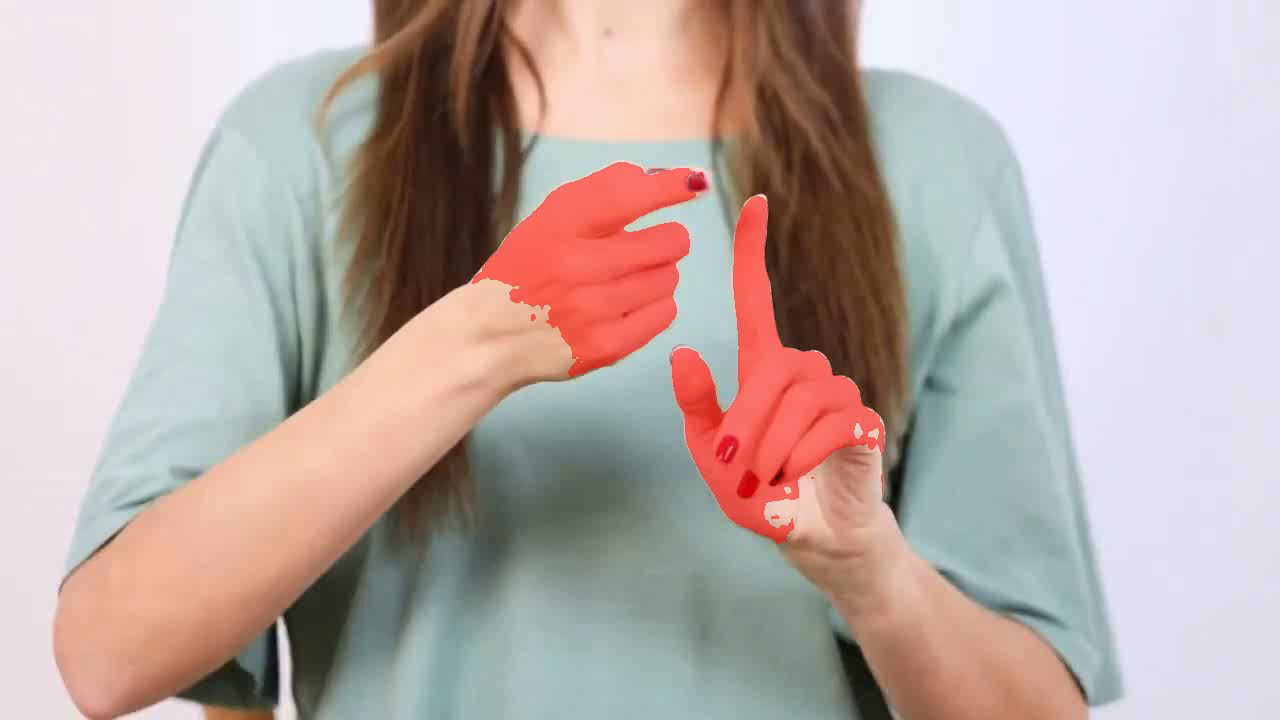

In [ ]:
# Run the pipeline
input_path = "/content/test.mp4"
output_path = "/content/output.mp4"
track_hands(input_path, output_path)
# Display preview
from google.colab.patches import cv2_imshow
cap = cv2.VideoCapture(output_path)
ret, frame = cap.read()
if ret:
    cv2_imshow(frame)
cap.release()